In [1]:
import pandas as pd
df = pd.read_csv('./Dataset/SixClass/train.csv')
df.head()

,Unnamed: 0,text,label,target
0,38746,#trumprussia sean spicer is a blithering idiot...,Others,4
1,47265,If you call yourself a Christian yet you suppo...,Religion,5
2,36632,Small red lights in dark rooms.,Others,4
3,29064,If u find yourself pouting that no male report...,Notcb,3
4,33884,Messi carried these retards to three consecuti...,Others,4


In [2]:
df.head(10)

,Unnamed: 0,text,label,target
0,38746,#trumprussia sean spicer is a blithering idiot...,Others,4
1,47265,If you call yourself a Christian yet you suppo...,Religion,5
2,36632,Small red lights in dark rooms.,Others,4
3,29064,If u find yourself pouting that no male report...,Notcb,3
4,33884,Messi carried these retards to three consecuti...,Others,4
5,26525,#MKR France Vs Ireland Vs Paleo Pete...LETS RU...,Notcb,3
6,41797,Today's front page of the New York Times. A fu...,Religion,5
7,33241,too bad I'm a size 11 men and got basketball t...,Others,4
8,11082,@_sarahjessiee @Khalil_Perry fuck that dumb as...,Ethnicity,1
9,44179,That Christian woman did the right thing,Religion,5


In [3]:
target_df = df.drop_duplicates().sort_values('target')

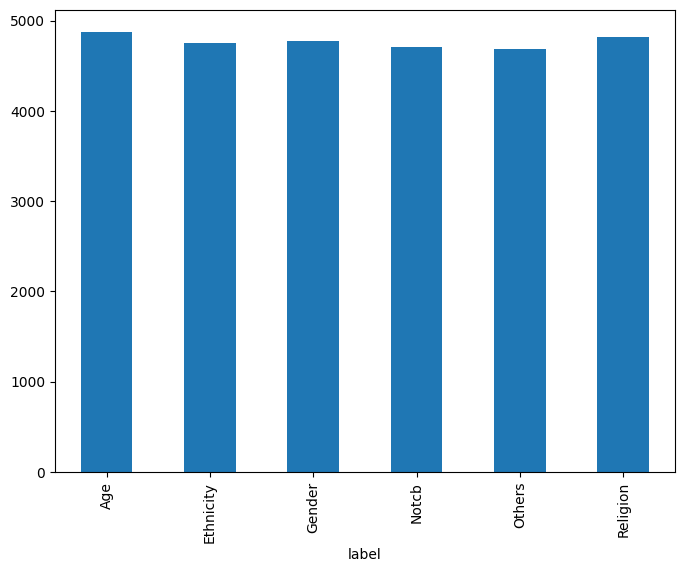

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, max_features=300, min_df=0.1, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.text).toarray()
labels = df.target
features.shape

(28623, 5)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    #LogisticRegression(solver='lbfgs', max_iter=400, random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

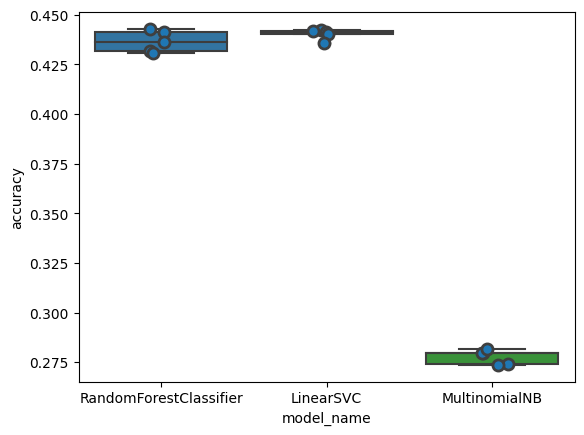

In [17]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_df.Label.values, yticklabels=target_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display

for predicted in target_df.target:
  for actual in target_df.target:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Label', 'text']])
      print('')

In [ ]:
model.fit(features, labels)

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Label'].unique()))